In [5]:
import maboss
from tqdm import tqdm
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

work_dir = '/home/spankaew/Git/benchmark-dynamical-models/'
project = 'toy_reprogramming_1'
model_dir = work_dir + 'files/02_model_synthesis/' + project + '/'
output_dir = work_dir + 'files/03_trajectory_simulations/' + project + '/'
traj_dir = work_dir + 'files/02_model_synthesis/'

In [6]:
traj_data = pd.read_csv(traj_dir + '/toy_reprogramming_traj_df.csv', index_col= 0)
initial_state = traj_data.loc['init']
node_inactive = list(initial_state.index[initial_state==0])
node_active = list(initial_state.index[initial_state==1])

In [7]:
# Create blank file to get the results
ensemble_results = {}
 
model_list = os.listdir(model_dir)

for model in tqdm(model_list):

    # Load model
    simulations = maboss.loadBNet(model_dir + model)

    # Setup the model initial condition
    ## Put all inputs at 0
    for i in node_inactive:
        simulations.network.set_istate(i,[1,0])
    ## Put all miR at 1
    for i in node_active:
        simulations.network.set_istate(i,[0,1])

    # Modify the parameter of the model
    simulations.update_parameters(sample_count = 10000,
                                  thread_count = 15,
                                  max_time = 20,
                                  time_tick = 1)
    simulations.network.set_output(simulations.network.names)

    # Perform simulations
    result = simulations.run()

    # Get matrix
    model_mtx = result.get_nodes_probtraj().copy()

    # Setup cell matrix
    ## Cells
    model_mtx['model_id'] = model.replace('.bnet','')
    ## Timepoint
    model_mtx['timepoint'] = model_mtx.index
    ## Change index
    model_mtx.index = model_mtx.index.map(str)
    model_mtx.index = model + '_' + model_mtx.index

    # Concatenate model results in dictionary
    ensemble_results[model] = model_mtx

# Save the simulation to /tmp folder
simulation_df = pd.concat(ensemble_results.values(), ignore_index = True)
simulation_df.to_csv(output_dir + 'simulation_df.csv')

100%|██████████| 9/9 [00:01<00:00,  7.42it/s]


In [8]:
cl_df = pd.read_csv(output_dir + 'simulation_df.csv', index_col = 0)
cl_df.index = cl_df.model_id + '_' + [str(f) for f in cl_df.timepoint]
cl_df.index.name = None

In [9]:
adata = sc.AnnData(cl_df.drop(['model_id','timepoint'],axis = 1))
adata.obs['timepoint'] = cl_df['timepoint']
adata.obs['model_id'] = cl_df['model_id']

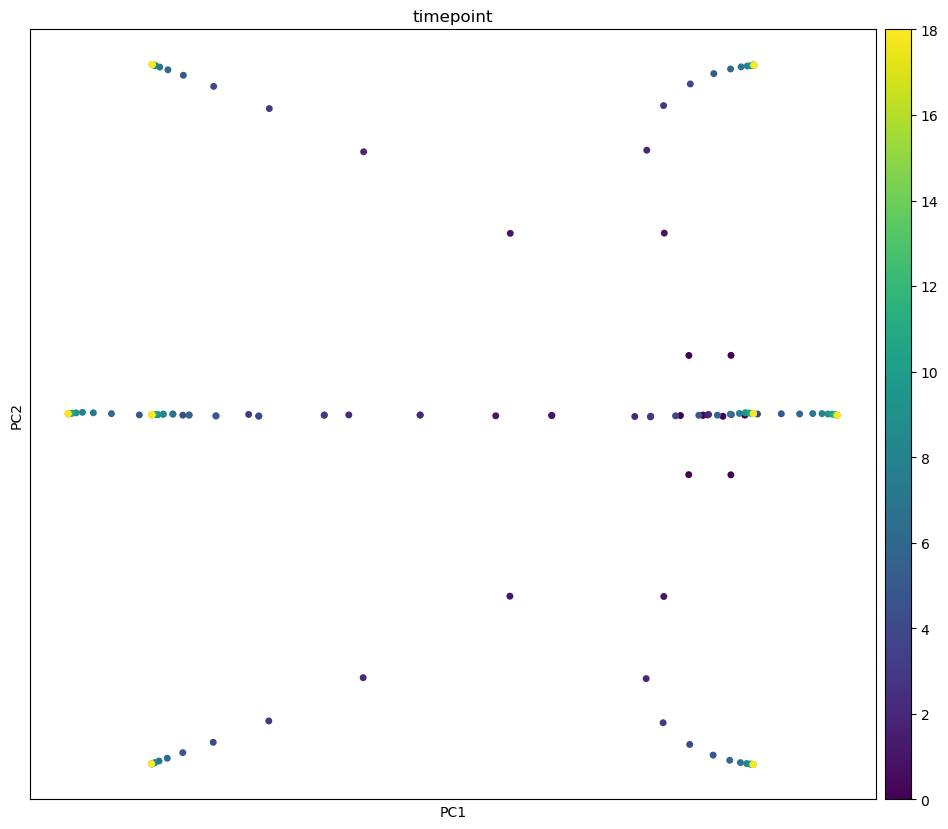

In [10]:
# Calculate PCA
sc.tl.pca(adata, svd_solver='arpack')

# plot 
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (12, 10)}):
    sc.pl.pca(adata, color = 'timepoint', size = 100)

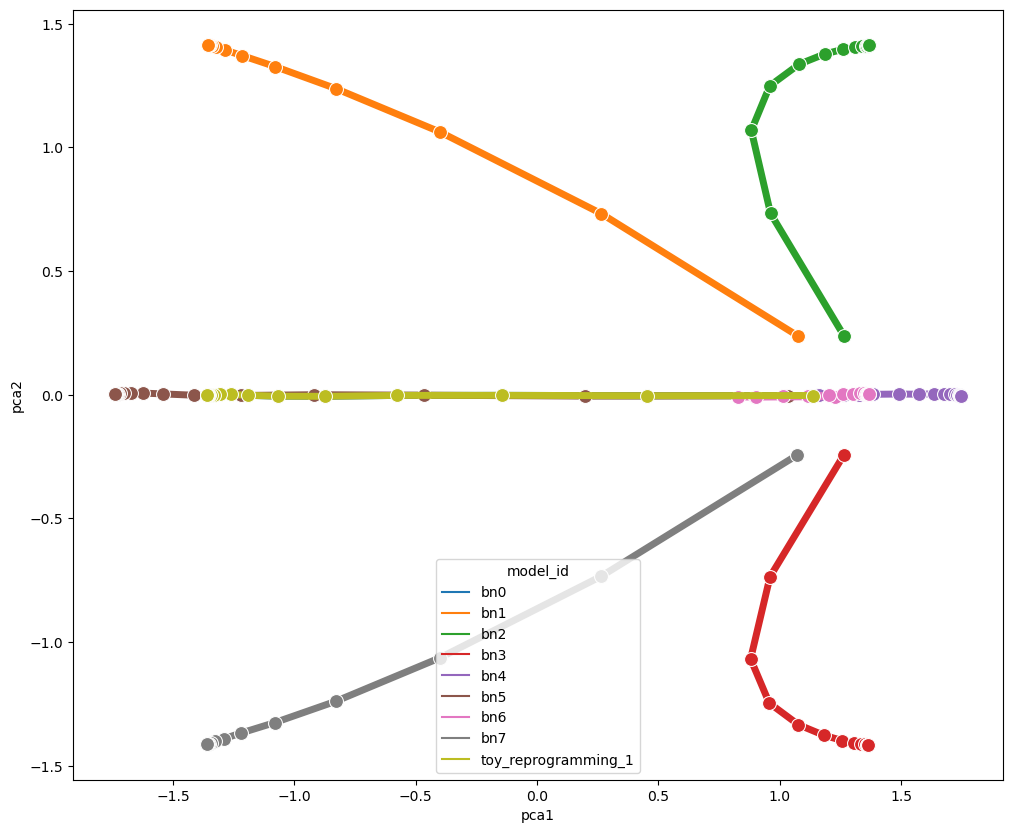

In [11]:
# Convert the PCA position to timeseries data
pca_mat = [array[:2] for array in adata.obsm['X_pca']]
pca_mat = pd.DataFrame(pca_mat, columns= ['pca1','pca2'])
pca_mat.index = adata.obs.index
pca_mat = pd.concat([pca_mat, adata.obs], axis = 1,ignore_index = False)

# plot
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'model_id', sort = False,
                        marker = 'o', linewidth = 5, markersize = 10)
    #plot.get_legend().remove()

plt.show()

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


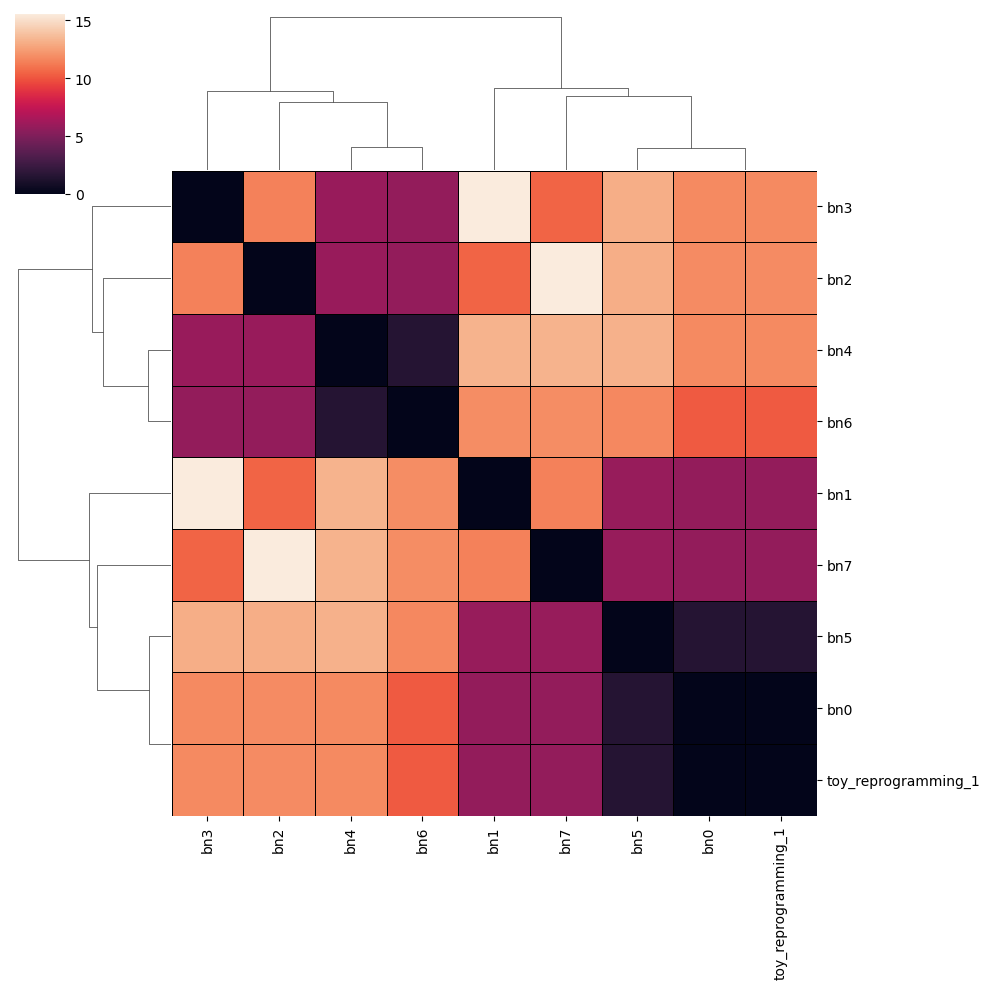

In [12]:
# Get model_id
model_id = list(pca_mat.model_id.cat.categories)

# Compact data into the right format
kmean_cluster = pca_mat.groupby(['model_id','timepoint'])[['pca1','pca2']].mean()

# Calculate Euclidean distances between clusters
distance_matrix = pd.DataFrame()
for i in model_id:
    time_series1 = np.array(kmean_cluster.loc[i])
    distance_cluster = []
    for j in model_id:
        time_series2 = np.array(kmean_cluster.loc[j])
        distance = np.sqrt(np.sum((time_series1 - time_series2)**2))
        distance_cluster.append(distance)
    distance_matrix = pd.concat([distance_matrix,pd.DataFrame(distance_cluster)],axis = 1)
distance_matrix.columns = model_id
distance_matrix.index = model_id

# Plot Euclidean distance using clustermap
g = sns.clustermap(distance_matrix, figsize = (10,10), linewidth = .5, linecolor ='black')

# Hiding the row dendrogram
#g.ax_row_dendrogram.set_visible(False)

# Hiding the column dendrogram
#g.ax_col_dendrogram.set_visible(False)

plt.show()